# Chest X-Ray Pneumonia Detection with VGG16 (PyTorch)

This notebook implements a deep learning model for classifying chest X-ray images as either Normal or Pneumonia using a pre-trained VGG16 network. We use PyTorch and follow a similar structure to the TensorFlow implementation while including data preprocessing, model definition, training, evaluation, and visualizations.

In [1]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from PIL import Image

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Determine device to run the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## 1. Dataset Paths and Preprocessing
Define the dataset directory and subdirectories for training, validation, and testing. We then define the image transformations for data augmentation (training) and normalization (validation and test).


In [2]:
# Define dataset paths (update these paths as needed)
dataset_path = "/Users/turragdewan/Documents/SUTD/TERM 8/Applied Deep Learning/chest_xray"
train_dir = os.path.join(dataset_path, "train")
val_dir   = os.path.join(dataset_path, "val")
test_dir  = os.path.join(dataset_path, "test")

### Image Transformations
For training we include several data augmentation techniques such as random flips, rotations, affine transforms, and color jitter. For validation and testing we simply resize and normalize the images.

In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

## 2. Create Datasets and DataLoaders
We use `ImageFolder` to load the images from each directory. Then we create DataLoaders for training, validation, and test splits.

In [4]:
# Create datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_dataset   = datasets.ImageFolder(root=val_dir, transform=val_test_transforms)
test_dataset  = datasets.ImageFolder(root=test_dir, transform=val_test_transforms)

print("Class indices:", train_dataset.class_to_idx)
print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))
print("Number of test samples:", len(test_dataset))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Number of training samples: 5216
Number of validation samples: 16
Number of test samples: 624


## 3. Model Definition: VGG16-Based Classifier
We use a pre-trained VGG16 network from `torchvision.models` and freeze its layers. Then we replace the classifier with our custom fully connected layers for binary classification.

In [5]:
class VGG16ChestXRay(nn.Module):
    def __init__(self, num_classes=1):
        super(VGG16ChestXRay, self).__init__()
        # Load pre-trained VGG16 model
        self.vgg16 = models.vgg16(pretrained=True)
        # Freeze all layers in VGG16
        for param in self.vgg16.parameters():
            param.requires_grad = False

        # Replace classifier with custom layers
        num_features = self.vgg16.classifier[0].in_features  # Typically 25088
        self.vgg16.classifier = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
            nn.Sigmoid()  # For binary classification
        )

    def forward(self, x):
        return self.vgg16(x)

model = VGG16ChestXRay().to(device)
print(model)

/Users/turragdewan/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/turragdewan/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG16ChestXRay(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
     

## 4. Loss, Optimizer, and Learning Rate Scheduler
We use Binary Cross-Entropy Loss (BCELoss) since this is a binary classification task. The Adam optimizer is used with a specified learning rate, and a scheduler reduces the learning rate when validation performance plateaus.


In [6]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=3, verbose=True)

/Users/turragdewan/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## 5. Training and Evaluation Functions
The following functions handle the training and evaluation of the model:
- **train_model**: Loops over epochs, performs training, validation, and saves the best model.
- **evaluate_model**: Runs the model on a given DataLoader to compute loss and accuracy.

In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, patience=5, delta=0.001):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0
    best_val_loss = float('inf')
    counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total

        # Evaluate on validation set
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        scheduler.step(val_acc)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_val_acc + delta:
            best_val_acc = val_acc
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_vgg16_chest_xray.pth")
            counter = 0  # Reset counter if improvement
        else:
            counter += 1
            print(f"EarlyStopping counter: {counter} out of {patience}")

        # Check if early stopping should trigger
        if counter >= patience:
            print(f"Stopping early at epoch {epoch+1}")
            break

    return history

def evaluate_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    loss = running_loss / len(loader.dataset)
    acc = correct / total
    return loss, acc

## 6. Training the Model
Now we train our model using the defined functions. After training, the best model is saved.

In [10]:
history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, patience=5, delta=0.001)

Epoch [1/30] Train Loss: 0.2865, Train Acc: 0.8831 | Val Loss: 0.1596, Val Acc: 0.9375
Epoch [2/30] Train Loss: 0.1962, Train Acc: 0.9191 | Val Loss: 0.1548, Val Acc: 0.9375
EarlyStopping counter: 1 out of 5
Epoch [3/30] Train Loss: 0.1846, Train Acc: 0.9258 | Val Loss: 0.1124, Val Acc: 1.0000
Epoch [4/30] Train Loss: 0.1687, Train Acc: 0.9304 | Val Loss: 0.0757, Val Acc: 1.0000
EarlyStopping counter: 1 out of 5
Epoch [5/30] Train Loss: 0.1649, Train Acc: 0.9342 | Val Loss: 0.1005, Val Acc: 0.9375
EarlyStopping counter: 2 out of 5
Epoch [6/30] Train Loss: 0.1611, Train Acc: 0.9375 | Val Loss: 0.0570, Val Acc: 1.0000
EarlyStopping counter: 3 out of 5
Epoch [7/30] Train Loss: 0.1576, Train Acc: 0.9371 | Val Loss: 0.0639, Val Acc: 1.0000
EarlyStopping counter: 4 out of 5
Epoch [8/30] Train Loss: 0.1523, Train Acc: 0.9433 | Val Loss: 0.0585, Val Acc: 1.0000
EarlyStopping counter: 5 out of 5
Stopping early at epoch 8


## 7. Testing the Model
We load the best saved model and evaluate its performance on the test set.

In [11]:
model.load_state_dict(torch.load("best_vgg16_chest_xray.pth"))
model.eval()
test_loss, test_acc = evaluate_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.3740, Test Accuracy: 0.8654


## 8. Visualizations
 
Here we define functions to visualize:

- Training history (loss and accuracy curves)
- Sample predictions on test images (with inverse normalization)
- Class distribution across train, validation, and test datasets


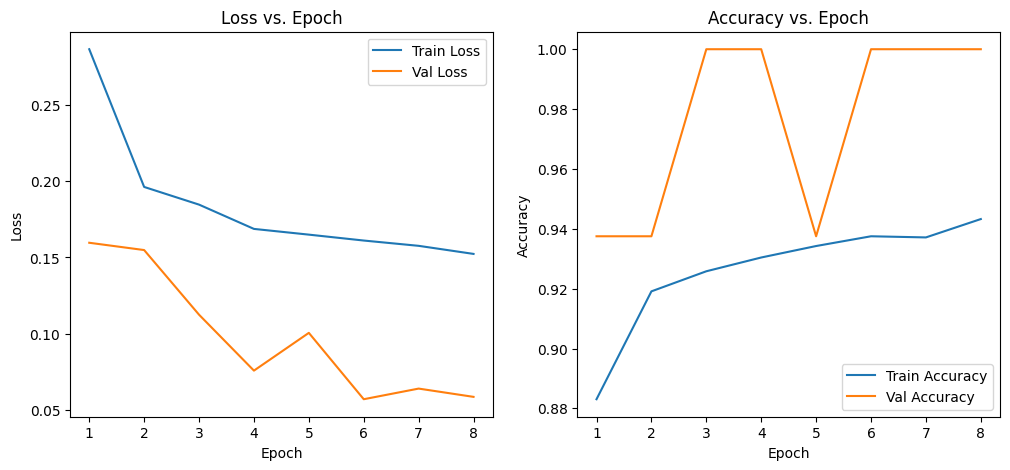

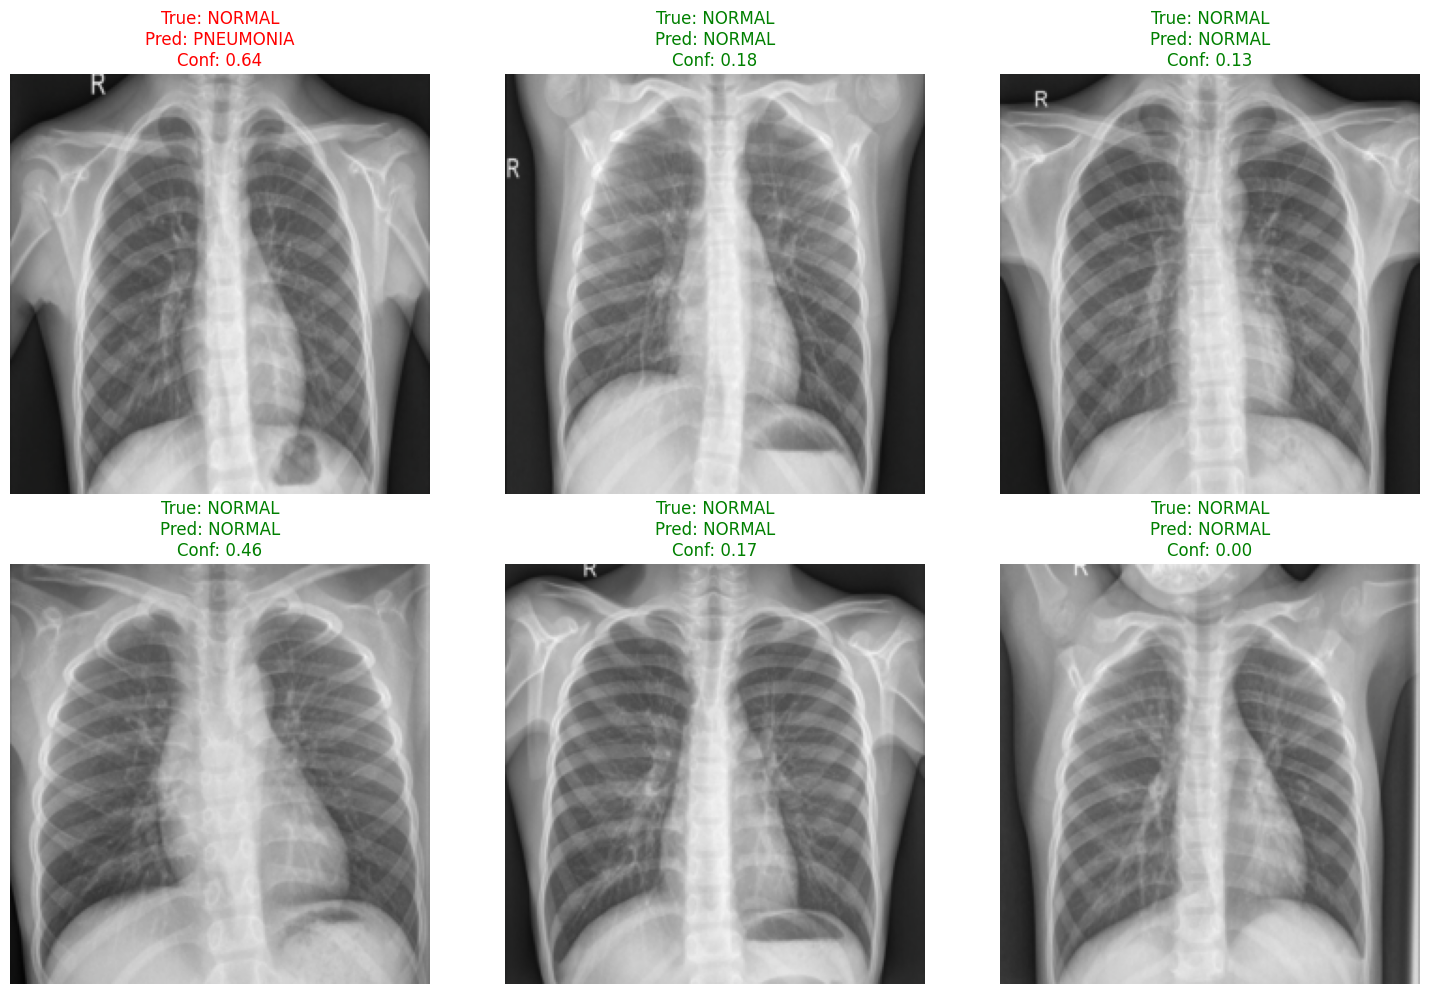

/var/folders/kg/0ysctqy944x32k8t0wmzmpvw0000gn/T/ipykernel_42246/2843437713.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=counts, palette="viridis")


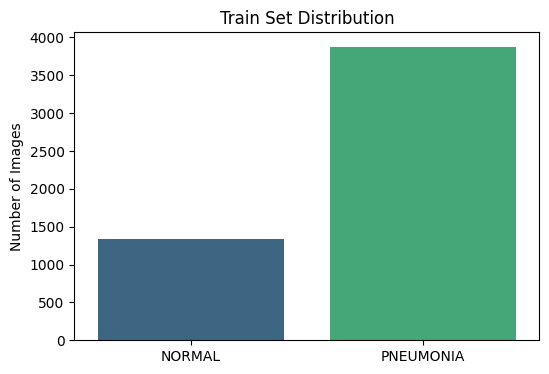

/var/folders/kg/0ysctqy944x32k8t0wmzmpvw0000gn/T/ipykernel_42246/2843437713.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=counts, palette="viridis")


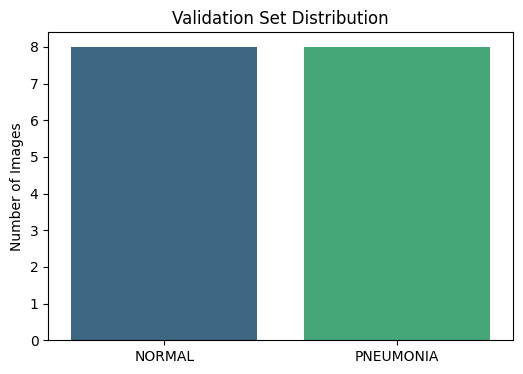

/var/folders/kg/0ysctqy944x32k8t0wmzmpvw0000gn/T/ipykernel_42246/2843437713.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=counts, palette="viridis")


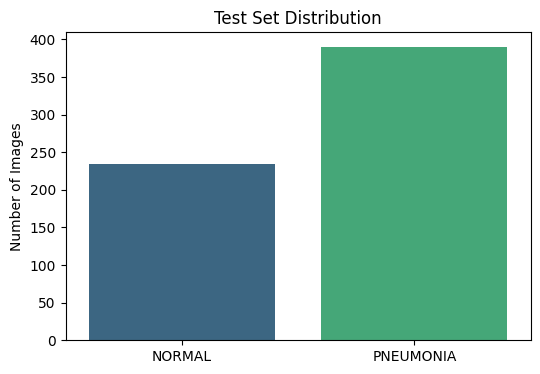

In [13]:
def plot_history(history):
    epochs = range(1, len(history['train_loss'])+1)
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs. Epoch")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Val Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs. Epoch")
    plt.legend()
    plt.show()

plot_history(history)

# %% [code]
def visualize_predictions(model, loader, num_images=6):
    model.eval()
    images, labels = next(iter(loader))
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images[:num_images])
        preds = (outputs > 0.5).float()

    # Inverse normalization for visualization
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )

    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(2, 3, i+1)
        img = inv_normalize(images[i]).cpu().permute(1, 2, 0).numpy()
        plt.imshow(np.clip(img, 0, 1))
        plt.axis("off")
        true_label = "NORMAL" if labels[i] == 0 else "PNEUMONIA"
        pred_label = "NORMAL" if preds[i] == 0 else "PNEUMONIA"
        title = f"True: {true_label}\nPred: {pred_label}\nConf: {outputs[i].item():.2f}"
        plt.title(title, color="green" if true_label == pred_label else "red")
    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_loader)

# %% [code]
def plot_class_distribution(dataset, title):
    classes = dataset.classes
    counts = [0] * len(classes)
    for _, label in dataset:
        counts[label] += 1
    plt.figure(figsize=(6, 4))
    sns.barplot(x=classes, y=counts, palette="viridis")
    plt.title(title)
    plt.ylabel("Number of Images")
    plt.show()

plot_class_distribution(train_dataset, "Train Set Distribution")
plot_class_distribution(val_dataset, "Validation Set Distribution")
plot_class_distribution(test_dataset, "Test Set Distribution")